Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

from data.stathinpy import draw_bs_reps_ind, draw_perm_reps

pd.set_option('display.max_columns', 100)
sns.set()
sns.set_style("white")


%matplotlib inline

### Read data

In [2]:
df = pd.read_csv('../data/processed/wound_outcomes_v1.csv')

### Value counts for ИСХОД

In [3]:
df['ИСХОД'].value_counts()

0    1882
1      65
2      15
Name: ИСХОД, dtype: int64

In [4]:
df = pd.get_dummies(df, columns=['тип', 'ВГА', 'ИСХОД'], drop_first=True)

# 'ИСХОД' = ИСХОД_1 OR ИСХОД_2
df['ИСХОД'] = df['ИСХОД_1'] + df ['ИСХОД_2']

In [5]:
df.head()

,Off pump,КШ,Соч,тип_П,тип_Т,ВГА_1,ВГА_2,ИСХОД_1,ИСХОД_2,ИСХОД
0,0,1,0,0,0,1,0,0,0,0
1,1,1,0,0,0,1,0,0,0,0
2,0,1,1,0,0,1,0,0,0,0
3,0,1,1,0,0,1,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0


### Bootstrap replicates and confidence interval for Outcome share

In [6]:
# Set seed
np.random.seed(42)

# Draw 100000 bootstrap replicates of outcomes ('ИСХОД') mean

data = df['ИСХОД'].values
bs_outcome_reps = draw_bs_reps_ind(data, np.mean, size=100000)

95% confidence interval for Outcome, %
[3.21100917 4.94520897]


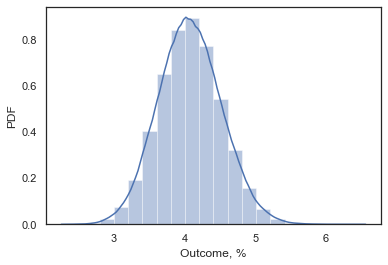

In [7]:
fig, ax = plt.subplots()
ax.set_ylabel('PDF')
ax.set_xlabel('Outcome, %')
_ = sns.distplot(bs_outcome_reps*100, bins=20, ax=ax)

print('95% confidence interval for Outcome, %' )
print(np.percentile(bs_outcome_reps*100, [2.5, 97.5]))

### Small multiples plot for Outcome share

In [8]:
df.columns

Index(['Off pump', 'КШ', 'Соч', 'тип_П', 'тип_Т', 'ВГА_1', 'ВГА_2', 'ИСХОД_1',
       'ИСХОД_2', 'ИСХОД'],
      dtype='object')

In [9]:
# Select columns to plot
columns = list(df.columns)
del columns [7:10]

# Specify cnum = number of columns in a plot
cnum = 3
# Calculate number of rows in a grid
rnum = round(len(columns)/cnum)+1

In [10]:
columns

['Off pump', 'КШ', 'Соч', 'тип_П', 'тип_Т', 'ВГА_1', 'ВГА_2']

In [11]:
def plot_cname_outcome_share(df, cname, ax):
    """plot_cname_outcome(df, cname, ax) generates plot from data `df` for the `cname` column on the `ax` axes"""
    data = df.groupby([cname]).agg(outcome_share=('ИСХОД','mean'), 
                                  outcome_sum=('ИСХОД','sum'), 
                                  count=('ИСХОД','size')).reset_index()
    data['outcome_share'] = data.outcome_share.round(2)
    
    sh = round(df['ИСХОД'].mean(), 2)
    
    ax.plot([-0.5, 1.5], [sh,sh], linestyle='--', alpha=0.3)
    
    ax.plot(data[cname],data['outcome_share'], alpha=0.8)
    ax.scatter(data[cname],data['outcome_share'], alpha=0.3, s=data['count']/2)
    for i in range(data.shape[0]):
        ax.annotate(data.loc[i, 'outcome_share'],
                   (data.loc[i, cname], data.loc[i, 'outcome_share']),
                   alpha=0.6)
    ax.set_title(cname)
    ax.margins(0.15)
    

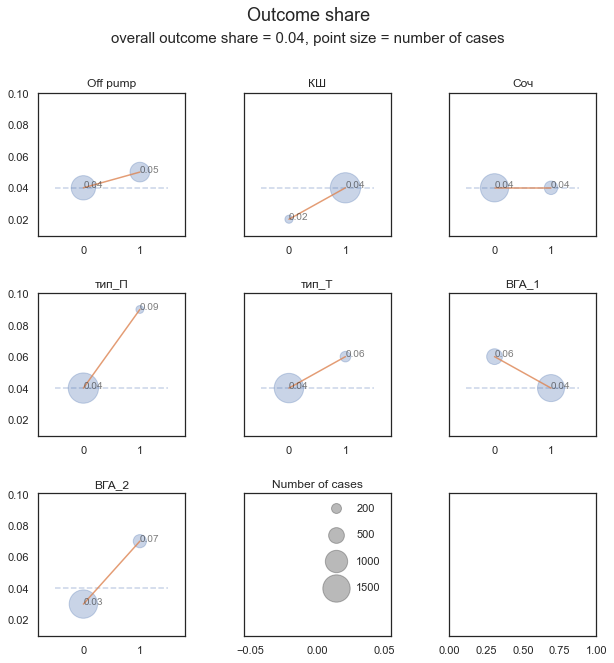

In [12]:
# Create subplots
fig, ax = plt.subplots(rnum, cnum, sharey=True, figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for rn in range(rnum):
        for cn in range(cnum):
            idx = rn*(cnum) + cn
            if (idx < len(columns)):
                plot_cname_outcome_share(df, cname=columns[idx], ax=ax[rn, cn]) 
            else:
                # Draw number of cases legend
                for s in [200, 500, 1000, 1500]:
                     ax[rn, cn].scatter([], [], alpha=0.3, s=s/2, label=str(s), c='k')
                ax[rn, cn].set_title('Number of cases')        
                ax[rn, cn].legend(scatterpoints=1, frameon=False, labelspacing=1.5)
                break
    
#fig.set_title('Outcome share')
plt.text(x=0.5, y=0.98, s="Outcome share", fontsize=18, ha="center", transform=fig.transFigure)
plt.text(x=0.5, y=0.95, s= 'overall outcome share = {}, point size = number of cases'.format(round(df['ИСХОД'].mean(), 2)), 
         fontsize=15, ha="center", transform=fig.transFigure)

plt.show()

In [13]:
def print_cname_outcome_share(df, cname):
    """print_cname_outcome(cname, ax) prints data for the `cname` column"""
    data = df.groupby([cname]).agg(outcome_share=('ИСХОД','mean'), 
                                  outcome_1_cases=('ИСХОД','sum'), 
                                  total_cases=('ИСХОД','size'))#.reset_index()
    data['outcome_share'] = data.outcome_share.round(2)
    print(data)       

### Outcome share in groups (numbers)

In [14]:
for idx in range(len(df.columns)-3):
    print('--------------------------------------------------------------------------\n')
    print_cname_outcome_share(df, df.columns[idx])
    print('\n')

--------------------------------------------------------------------------

          outcome_share  outcome_1_cases  total_cases
Off pump                                             
0                  0.04               43         1187
1                  0.05               37          775


--------------------------------------------------------------------------

    outcome_share  outcome_1_cases  total_cases
КШ                                             
0            0.02                2          131
1            0.04               78         1831


--------------------------------------------------------------------------

     outcome_share  outcome_1_cases  total_cases
Соч                                             
0             0.04               66         1598
1             0.04               14          364


--------------------------------------------------------------------------

       outcome_share  outcome_1_cases  total_cases
тип_П                              